# Loading Data

In [2]:
n_classes = 100
n_repetitions = 4

n_images_per_class = 10

In [3]:
from PIL import Image
import glob

import scipy.io
import os
import numpy as np

def load_images_from_folder(folder, size=(64, 64)):
    images = []
    for filename in glob.glob(f'{folder}/*.jpg'): # Adjust the path if needed
        with Image.open(filename) as img:
            img = img.resize(size)
            images.append(np.array(img))
    return np.array(images)

In [7]:
from tqdm import tqdm

def load_dataset(base_path, n_objects, n_images_per_object=10):
    all_images = []
    for i in tqdm(range(n_objects), desc="Loading Images"):
        folder_name = os.path.join(base_path, f'{i:05d}_*')  # Adjust the format as per your folder naming
        for folder in glob.glob(folder_name):
            images = load_images_from_folder(folder)
            all_images.extend(images)
    return np.array(all_images)

# Load dataset
dataset_path = os.path.join('training_images')
dataset = load_dataset(dataset_path, n_classes+1)

# Normalize the dataset
images50 = dataset / 255.0  # Normalize pixel values to [0, 1]

images50.shape

Loading Images: 100%|██████████| 101/101 [00:04<00:00, 24.06it/s]


(1000, 64, 64, 3)

In [8]:
#loading in eeg data
eeg_parent_dir = os.path.join('sub-01')
eeg_data_train = np.load(os.path.join(eeg_parent_dir,
    'preprocessed_eeg_training.npy'), allow_pickle=True).item()
eeg_data_test = np.load(os.path.join(eeg_parent_dir,
    'preprocessed_eeg_test.npy'), allow_pickle=True).item()

eeg_data_train_sub_1 = eeg_data_train['preprocessed_eeg_data']
eeg_data_test_sub_1 = eeg_data_test['preprocessed_eeg_data']

In [9]:
total_images_needed = n_classes * n_images_per_class

# Slicing the EEG data to include only the first 500 (50 classes * 10 images each)
eegs50 = eeg_data_train['preprocessed_eeg_data'][:total_images_needed]

# Verify the new shape of the EEG data
print("New shape of training EEG data:")
print(eegs50.shape)  # Should output (500, 4, 17, 100)

New shape of training EEG data:
(1000, 4, 17, 100)


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

images50_tensor = torch.tensor(images50).float()
eegs50_tensor = torch.tensor(eegs50).float()

images50_tensor = images50_tensor.reshape(-1, 64*64*3)
images50_tensor = images50_tensor.repeat_interleave(n_repetitions, dim=0)

eegs50_tensor = eegs50_tensor.permute(1, 0, 2, 3)
eegs50_tensor = eegs50_tensor.reshape(-1, 17, 100)
eegs50_tensor = eegs50_tensor.flatten(start_dim=1)

print(images50_tensor.shape)
print(eegs50_tensor.shape)

torch.Size([4000, 12288])
torch.Size([4000, 1700])


In [13]:
average_one_hot_vector = torch.ones(n_classes) / n_classes
average_one_hot_matrix = average_one_hot_vector.repeat(eegs50_tensor.shape[0], 1)

eegs50_unknown_conditionals_tensor = torch.cat((eegs50_tensor, average_one_hot_matrix), dim=1)

print(eegs50_unknown_conditionals_tensor.shape)

torch.Size([4000, 1800])


In [14]:
one_hot_vectors = np.eye(n_classes)

# Repeat each vector 40 times and concatenate them to form the matrix
one_hot_matrix = torch.tensor(np.concatenate([np.tile(vector, (n_repetitions * n_images_per_class, 1)) for vector in one_hot_vectors]))

eegs50_known_conditionals_tensor = torch.cat((eegs50_tensor, one_hot_matrix), dim=1)

print(eegs50_known_conditionals_tensor.shape)
print(eegs50_known_conditionals_tensor[39:41, 1700:1710])

torch.Size([4000, 1800])
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)


In [15]:
# Making Train and Test Splits for EEG Data
eegs50_train = []
eegs50_known_test = []
eegs50_unknown_train = []
eegs50_unknown_test = []

eegs50_raw_train = []
eegs50_raw_test = []

images50_train = []
images50_test = []

onehot50_train = []
onehot50_test = []

for i in range(eegs50_known_conditionals_tensor.shape[0]):
    if i % (n_repetitions * n_images_per_class) >= (n_repetitions * n_images_per_class - n_repetitions) and i % (n_repetitions * n_images_per_class) <= (n_repetitions * n_images_per_class):
        eegs50_known_test.append(torch.tensor(eegs50_known_conditionals_tensor[i]))
        eegs50_unknown_test.append(torch.tensor(eegs50_unknown_conditionals_tensor[i]))
        eegs50_raw_test.append(torch.tensor(eegs50_tensor[i]))
        images50_test.append(torch.tensor(images50_tensor[i]))
        onehot50_test.append(torch.tensor(one_hot_matrix[i]))
    else:
        eegs50_train.append(torch.tensor(eegs50_known_conditionals_tensor[i]))
        eegs50_unknown_train.append(torch.tensor(eegs50_unknown_conditionals_tensor[i]))
        eegs50_raw_train.append(torch.tensor(eegs50_tensor[i]))
        images50_train.append(torch.tensor(images50_tensor[i]))
        onehot50_train.append(torch.tensor(one_hot_matrix[i]))

# Convert lists back to tensors
eegs50_train = torch.stack(eegs50_train).float()
eegs50_known_test = torch.stack(eegs50_known_test).float()
eegs50_unknown_train = torch.stack(eegs50_unknown_train).float()
eegs50_unknown_test = torch.stack(eegs50_unknown_test).float()

eegs50_raw_train = torch.stack(eegs50_raw_train).float()
eegs50_raw_test = torch.stack(eegs50_raw_test).float()

images50_train = torch.stack(images50_train).float()
images50_test = torch.stack(images50_test).float()

onehot50_train = torch.stack(onehot50_train).float()
onehot50_test = torch.stack(onehot50_test).float()

eegs50_train.shape, eegs50_unknown_test.shape

/var/folders/bc/y584nv9d3qx21nb9hbpkfx340000gp/T/ipykernel_11157/1593036897.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eegs50_train.append(torch.tensor(eegs50_known_conditionals_tensor[i]))
/var/folders/bc/y584nv9d3qx21nb9hbpkfx340000gp/T/ipykernel_11157/1593036897.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eegs50_unknown_train.append(torch.tensor(eegs50_unknown_conditionals_tensor[i]))
/var/folders/bc/y584nv9d3qx21nb9hbpkfx340000gp/T/ipykernel_11157/1593036897.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eegs5

(torch.Size([3600, 1800]), torch.Size([400, 1800]))

In [16]:
import torch
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(eegs50_raw_train, images50_train)

# Create a DataLoader
batch_size = 32  # You can adjust the batch size

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Conditional VAE

In [17]:
class CVAE(nn.Module):
    def __init__(self, eeg_size, image_size, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim

        # EEG encoder
        self.eeg_encoder = nn.Sequential(
            nn.Linear(eeg_size, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim * 2)  # Outputting mean and log-variance
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, image_size),
            nn.Sigmoid()  # Assuming images are normalized between 0 and 1
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, eeg):

        eeg_latent = self.eeg_encoder(eeg)

        # Split the result into mean and log-variance
        mu, log_var = torch.chunk(eeg_latent, 2, dim=1)

        z = self.reparameterize(mu, log_var)
        recon_image = self.decoder(z)
        return recon_image, mu, log_var

# Initialize the model
eeg_size = 17 * 100 + 50  # Adjust according to your EEG data shape
image_size = 64 * 64 * 3  # Adjust for your image size
latent_dim = 5  # You can experiment with this
cvae = CVAE(eeg_size, image_size, latent_dim)

In [18]:
def cvae_loss(recon_image, original_image, mu, log_var):
    # Reconstruction loss (MSE for simplicity)
    recon_loss = F.mse_loss(recon_image, original_image, reduction='sum')

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    return recon_loss + kl_loss, recon_loss, kl_loss

In [19]:
from tqdm import tqdm

optimizer = torch.optim.Adam(cvae.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cvae = cvae.to(device)
num_epochs = 500

# Example training loop
for epoch in range(num_epochs):
    # Wrap your data loader with tqdm for a progress bar
    loop = tqdm(data_loader, leave=True)

    for eeg, image in loop:  # Assuming your data loader provides paired EEG and image data
        eeg, image = eeg.to(device), image.to(device)

        # Forward pass
        recon_image, mu, log_var = cvae(eeg)

        # Compute loss
        loss, recon_loss, kl_loss = cvae_loss(recon_image, image, mu, log_var)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the progress bar
        loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        loop.set_postfix(loss=loss.item())

# Close the tqdm loop after the epoch ends
loop.close()

  0%|          | 0/113 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x1700 and 1750x128)

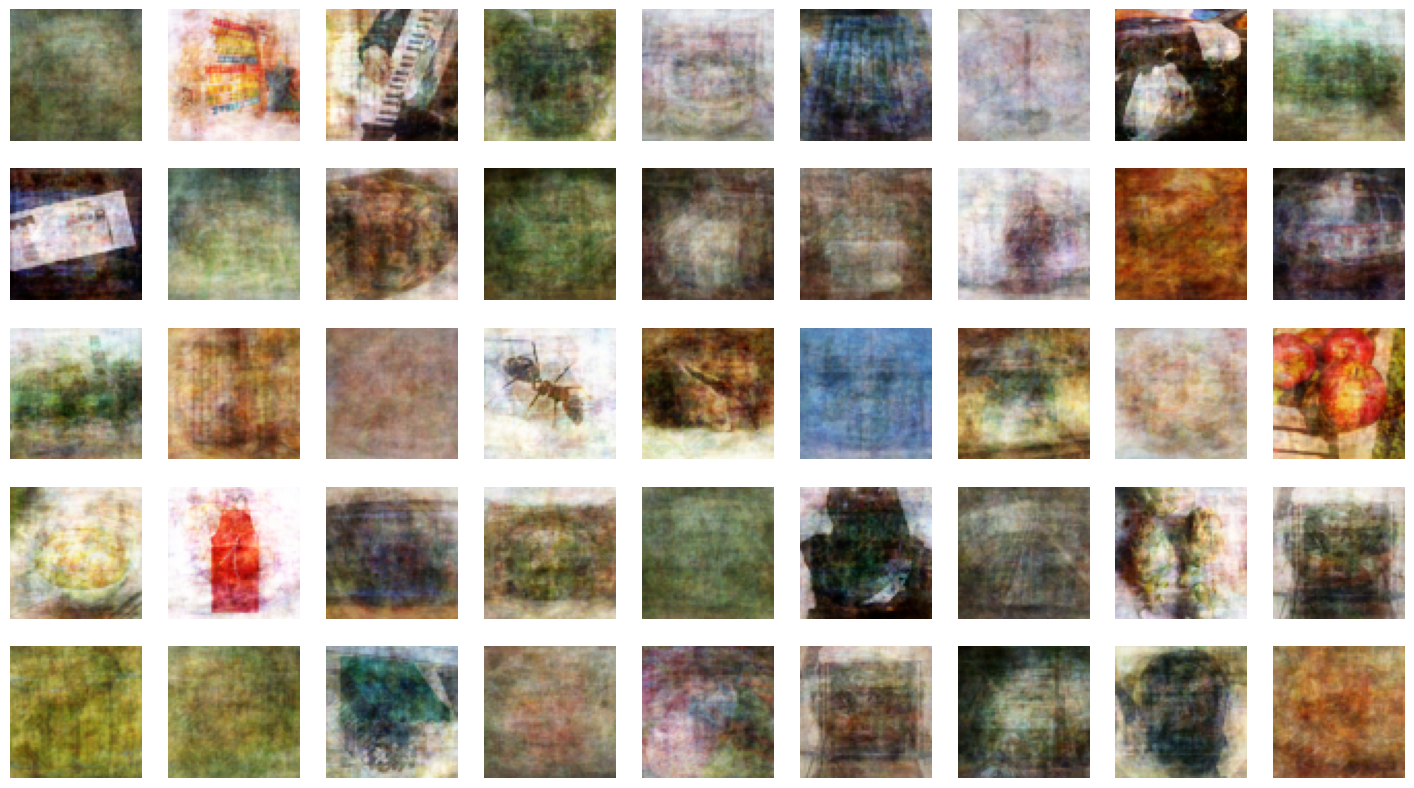

In [ ]:
import matplotlib.pyplot as plt

# Select the first 10 EEG scans
eeg_samples = eegs50_train[::40]

# Forward pass through the model
with torch.no_grad():
    reconstructed_images, _, _ = cvae(eeg_samples.to(device))

# Convert the reconstructed images to NumPy for visualization
reconstructed_images = reconstructed_images.detach().cpu().numpy()
real_images = images50_test[0:8]

# Reshape and scale the images as needed for visualization
reconstructed_images = reconstructed_images.reshape(-1, 64, 64, 3)
real_images = real_images.reshape(-1, 64, 64, 3)

# Number of rows and columns
n_cols = 9
n_rows = eeg_samples.shape[0] // n_cols

# Plotting
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))  # Adjust figsize if needed
for i, ax in enumerate(axes.flatten()):
    if i < len(reconstructed_images):
        ax.imshow(reconstructed_images[i])
        ax.axis('off')
    else:
        ax.axis('off')  # Hide axes for any unused subplots

plt.show()

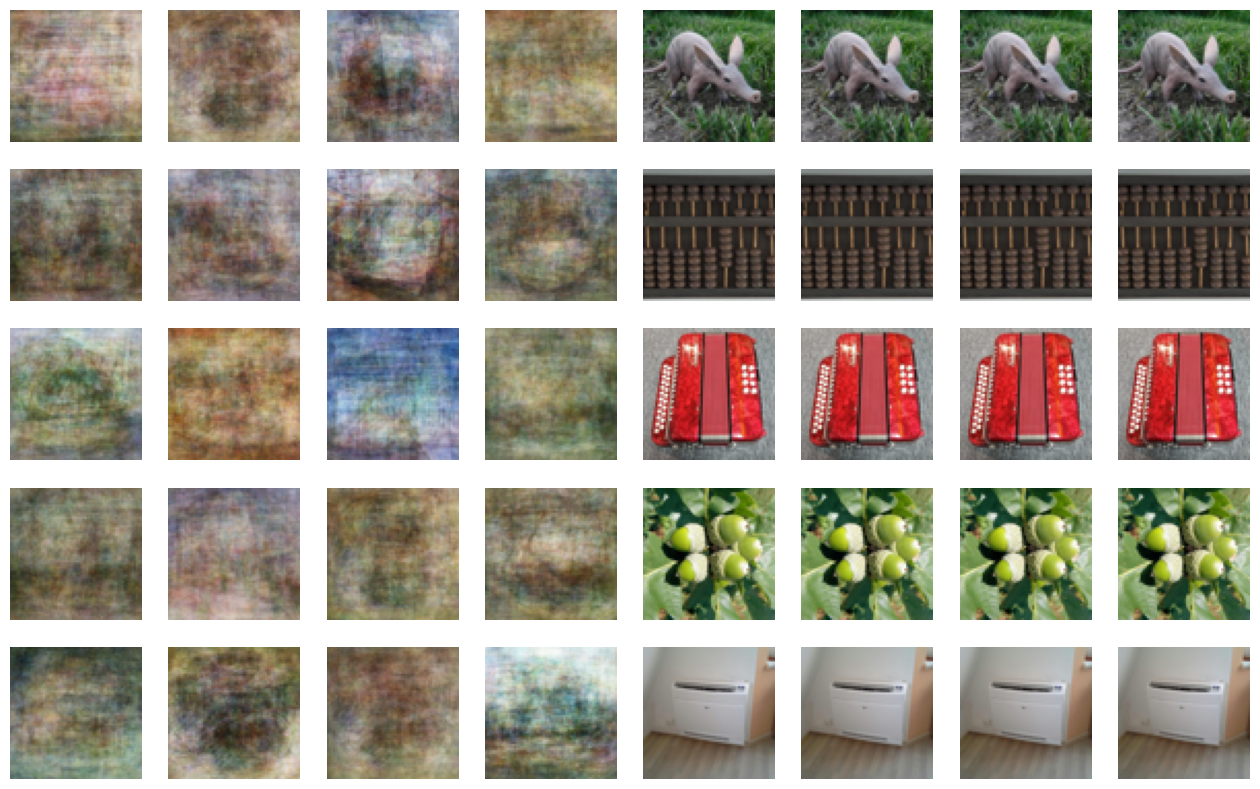

In [ ]:
import matplotlib.pyplot as plt

# Assuming eegs50_known_test, cvae, device, and images50_test are already defined

# Select the first 8 EEG scans
eeg_samples = eegs50_unknown_test[0:20]

# Forward pass through the model
with torch.no_grad():
    reconstructed_images, _, _ = cvae(eeg_samples.to(device))

# Convert the reconstructed images to NumPy for visualization
reconstructed_images = reconstructed_images.detach().cpu().numpy()
real_images = images50_test[0:20]

# Reshape and scale the images as needed for visualization
reconstructed_images = reconstructed_images.reshape(-1, 64, 64, 3)
real_images = real_images.reshape(-1, 64, 64, 3)

# Number of rows and columns
n_cols = 8  # Adjusted to 8 for both reconstructed and real images
n_rows = eeg_samples.shape[0] // 4  # Assuming you want to keep 4 rows

# Plotting
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
for row in range(n_rows):
    for col in range(n_cols // 2):
        idx = row * (n_cols // 2) + col
        if idx < len(reconstructed_images):
            axes[row, col].imshow(reconstructed_images[idx])
            axes[row, col].axis('off')
        else:
            axes[row, col].axis('off')  # Hide axes for any unused subplots
        if idx < len(real_images):
            axes[row, col + n_cols // 2].imshow(real_images[idx])
            axes[row, col + n_cols // 2].axis('off')
        else:
            axes[row, col + n_cols // 2].axis('off')  # Hide axes for any unused subplots

plt.show()

In [ ]:
torch.save(cvae.state_dict(), mount_file_header + '/vae_condition.pth')

# Siamese

In [20]:
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
import random

class EEGTripletDataset(Dataset):
    def __init__(self, eegs, images, labels):
        self.eegs = eegs
        self.images = images
        self.labels = labels

        self.labels_set = set(labels.numpy())
        self.label_to_indices = {label: np.where(labels.numpy() == label)[0]
                                 for label in self.labels_set}

    def __getitem__(self, index):
        eeg1, img1, label1 = self.eegs[index], self.images[index], self.labels[index].item()

        # Positive example
        positive_index = index
        while positive_index == index:
            positive_index = np.random.choice(self.label_to_indices[label1])
        eeg2, img2 = self.eegs[positive_index], self.images[positive_index]

        # Negative example
        negative_label = np.random.choice(list(self.labels_set - {label1}))
        negative_index = np.random.choice(self.label_to_indices[negative_label])
        eeg3, img3 = self.eegs[negative_index], self.images[negative_index]

        return (eeg1, eeg2, eeg3), (img1, img2, img3)

    def __len__(self):
        return len(self.eegs)

# Initialize the dataset
eegs_tensor = eegs50_raw_train  # EEG data tensor
images_tensor = images50_train  # Images data tensor
labels_tensor = onehot50_train.argmax(dim=1)  # Convert one-hot to integer labels

triplet_dataset = EEGTripletDataset(eegs_tensor, images_tensor, labels_tensor)

# DataLoader
batch_size = 32
triplet_dataloader = DataLoader(triplet_dataset, batch_size=batch_size, shuffle=True)

In [21]:
class SIAVAE(nn.Module):
    def __init__(self, eeg_size, image_size, latent_dim):
        super(SIAVAE, self).__init__()
        self.latent_dim = latent_dim

        # EEG encoder
        self.eeg_encoder = nn.Sequential(
            nn.Linear(eeg_size, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim * 2)  # Outputting mean and log-variance
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, image_size),
            nn.Sigmoid()  # Assuming images are normalized between 0 and 1
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, eeg):

        eeg_latent = self.eeg_encoder(eeg)

        # Split the result into mean and log-variance
        mu, log_var = torch.chunk(eeg_latent, 2, dim=1)

        z = self.reparameterize(mu, log_var)
        recon_image = self.decoder(z)
        return recon_image, z, mu, log_var

# Initialize the model
eeg_size = 17 * 100  # Adjust according to your EEG data shape
image_size = 64 * 64 * 3  # Adjust for your image size
latent_dim = 25  # You can experiment with this
siavae = SIAVAE(eeg_size, image_size, latent_dim)

In [22]:
from tqdm import tqdm
import torch
import torch.nn as nn

# Assuming siamese_network is your Siamese Network model
# and triplet_loss is your contrastive loss function

optimizer = torch.optim.Adam(siavae.parameters(), lr=0.0005)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
siavae = siavae.to(device)
num_epochs = 100

triplet_loss = nn.TripletMarginLoss(reduction='sum')

recon_losses = []
kl_losses = []
siamese_losses = []

def siamese_loss_weight(epoch, start_epoch=50, end_epoch=100):
    if epoch < start_epoch:
        return 0.0
    elif epoch > end_epoch:
        return 1.0
    else:
        optimizer.lr = 0.0001
        return (epoch - start_epoch) / (end_epoch - start_epoch)

# Example training loop
for epoch in range(num_epochs):
    loop = tqdm(triplet_dataloader, leave=True)  # data_loader yields (eeg_triplet, image_triplet)
    # current_siamese_weight = 0.2

    total_recon_loss, total_kl_loss, total_siamese_loss = 0, 0, 0

    for (anchor_eeg, positive_eeg, negative_eeg), (anchor_img, positive_img, negative_img) in loop:
        anchor_eeg, positive_eeg, negative_eeg = anchor_eeg.to(device), positive_eeg.to(device), negative_eeg.to(device)
        anchor_img, positive_img, negative_img = anchor_img.to(device), positive_img.to(device), negative_img.to(device)

        # Forward pass for VAE (reconstruction) and Siamese (embeddings)
        reconstructed_anchor, anchor_embedding, anchor_mu, anchor_log_var = siavae(anchor_eeg)
        reconstructed_positive, positive_embedding, positive_mu, positive_log_var = siavae(positive_eeg)
        reconstructed_negative, negative_embedding, negative_mu, negative_log_var = siavae(negative_eeg)

        # Compute VAE loss
        recon_loss = F.mse_loss(reconstructed_anchor, anchor_img, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + anchor_log_var - anchor_mu.pow(2) - anchor_log_var.exp())
        siamese_loss = triplet_loss(anchor_embedding, positive_embedding, negative_embedding)

        loss = 0.0015 * recon_loss + 0.0003 * kl_loss + siamese_loss

        # Accumulate losses
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item()
        total_siamese_loss += siamese_loss.item()

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        loop.set_postfix(recon_loss=total_recon_loss, kl_loss=total_kl_loss, siamese_loss=total_siamese_loss)

    loop.close()

    num_batches = len(triplet_dataloader)
    recon_losses.append(total_recon_loss / num_batches)
    kl_losses.append(total_kl_loss / num_batches)
    siamese_losses.append(total_siamese_loss / num_batches)

Epoch [12/100]:  51%|█████▏    | 58/113 [00:00<00:00, 63.54it/s, kl_loss=6.07e+4, recon_loss=1.54e+6, siamese_loss=1.67e+3]

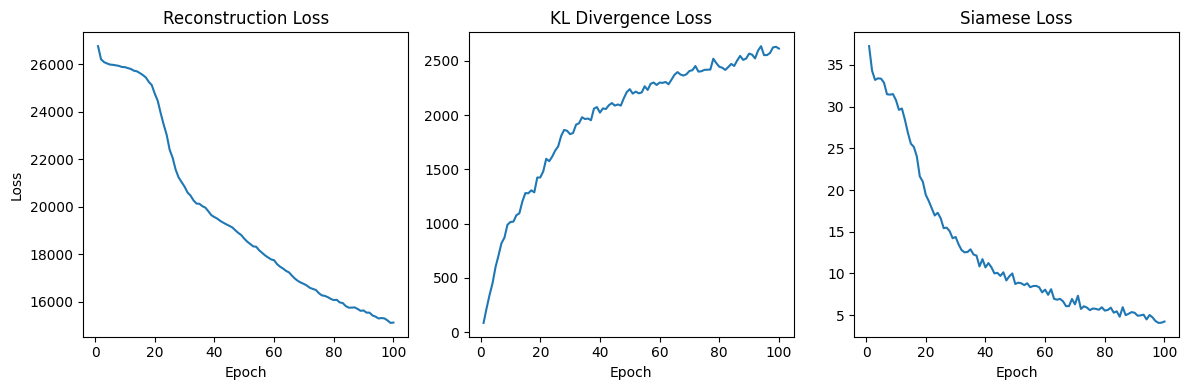

In [ ]:
# Plotting the losses
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(epochs, recon_losses, label='Reconstruction Loss')
plt.title('Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 3, 2)
plt.plot(epochs, kl_losses, label='KL Divergence Loss')
plt.title('KL Divergence Loss')
plt.xlabel('Epoch')

plt.subplot(1, 3, 3)
plt.plot(epochs, siamese_losses, label='Siamese Loss')
plt.title('Siamese Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

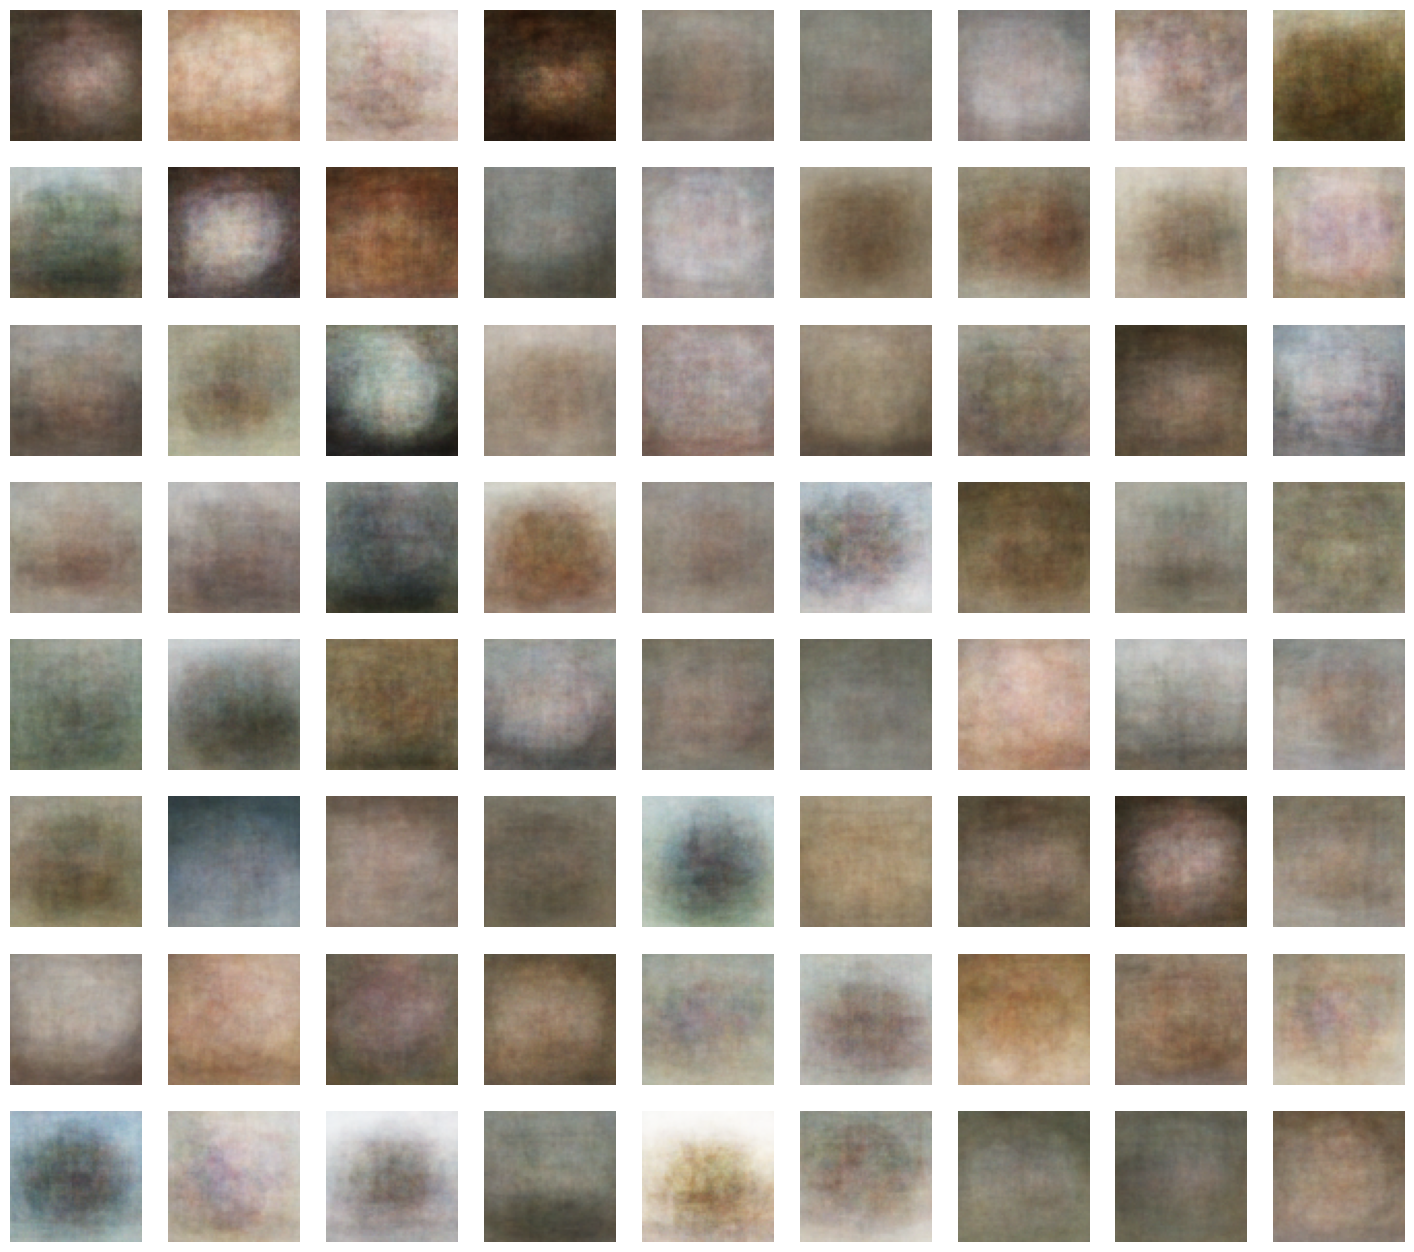

In [ ]:
import matplotlib.pyplot as plt

siavae = siavae.to(device)

# Select the first 10 EEG scans
eeg_samples = eegs50_raw_test[0:72]

# Forward pass through the model
with torch.no_grad():
    reconstructed_images, _, _, _ = siavae(eeg_samples.to(device))

# Convert the reconstructed images to NumPy for visualization
reconstructed_images = reconstructed_images.detach().cpu().numpy()

# Reshape and scale the images as needed for visualization
reconstructed_images = reconstructed_images.reshape(-1, 64, 64, 3)

# Number of rows and columns
n_cols = 9
n_rows = eeg_samples.shape[0] // n_cols

# Plotting
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))  # Adjust figsize if needed
for i, ax in enumerate(axes.flatten()):
    if i < len(reconstructed_images):
        ax.imshow(reconstructed_images[i])
        ax.axis('off')
    else:
        ax.axis('off')  # Hide axes for any unused subplots

plt.show()

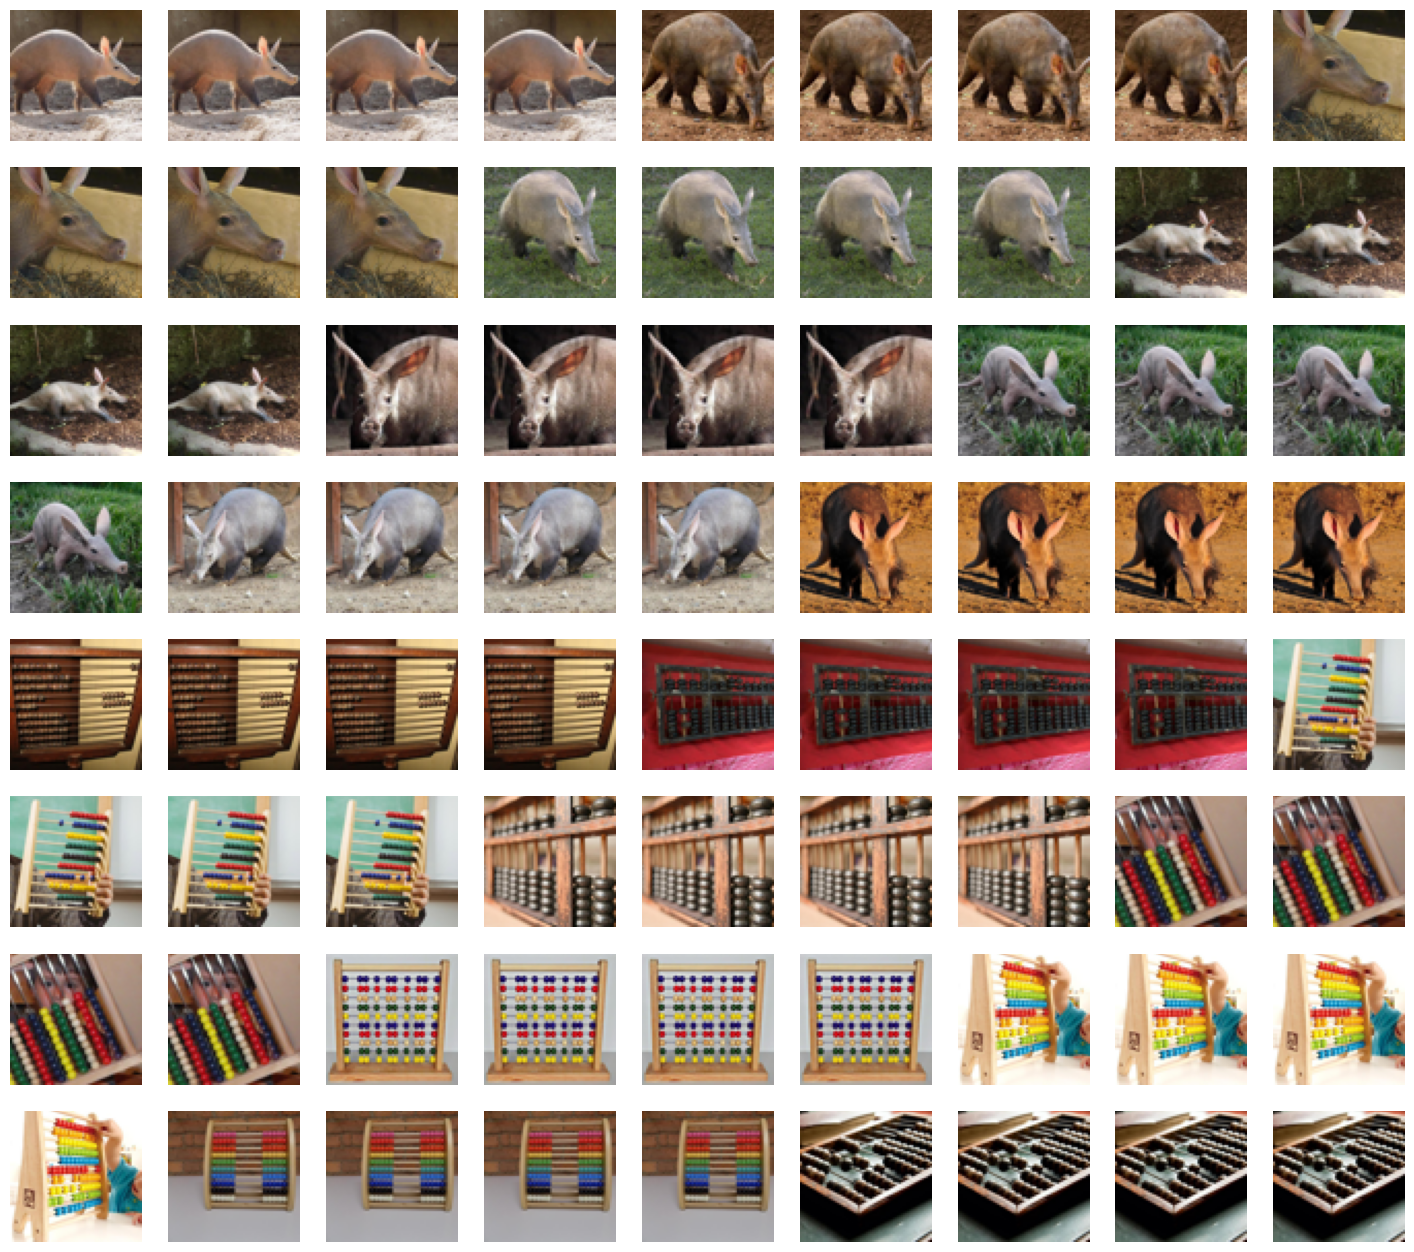

In [ ]:
import matplotlib.pyplot as plt

real_images = images50_train[0:72]

# Convert the reconstructed images to NumPy for visualization
real_images = real_images.detach().cpu().numpy()

# Reshape and scale the images as needed for visualization
real_images = real_images.reshape(-1, 64, 64, 3)

# Number of rows and columns
n_cols = 9
n_rows = real_images.shape[0] // n_cols

# Plotting
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))  # Adjust figsize if needed
for i, ax in enumerate(axes.flatten()):
    if i < len(real_images):
        ax.imshow(real_images[i])
        ax.axis('off')
    else:
        ax.axis('off')  # Hide axes for any unused subplots

plt.show()

In [ ]:
recon_image, z, mu, log_var = siavae(eegs50_raw_train.to(device))

train_latents = mu.detach()
train_labels = onehot50_train.detach()

print(train_latents.shape)
print(train_labels.shape)

torch.Size([3600, 25])
torch.Size([3600, 100])


In [ ]:
torch.norm(train_latents[0] - train_latents[45])

tensor(3.4336, device='cuda:0')

# Classifier on Latents

In [ ]:
model = siavae.to(device)

In [ ]:
recon_image, z, mu, log_var = model(eegs50_raw_train.to(device))

classifier_inputs_tensor = z.detach()
classifier_outputs_tensor = onehot50_train.detach()

classifier_inputs_np = classifier_inputs_tensor.cpu().numpy()
classifier_outputs_np = classifier_outputs_tensor.cpu().numpy()

print(classifier_inputs_np.shape)
print(classifier_outputs_np.shape)

(3600, 25)
(3600, 100)


In [ ]:
_, test_latents, _, _ = model(eegs50_raw_test.to(device))

test_inputs_tensor = test_latents.detach()
test_outputs_tensor = onehot50_test.detach()

test_inputs_np = test_inputs_tensor.cpu().numpy()
test_outputs_np = test_outputs_tensor.cpu().numpy()

test_inputs_np.shape

(400, 25)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiClassClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MultiClassClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size // 4, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out

# Assuming your latent vector size and number of classes
input_size = 25
hidden_size = 128  # You can experiment with this
num_classes = 100  # As you have 50 image classes
classifier_model = MultiClassClassifier(input_size, hidden_size, num_classes)

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

cvae_class_dataset = TensorDataset(classifier_inputs_tensor, classifier_outputs_tensor)

cvae_class_data_loader = DataLoader(cvae_class_dataset, batch_size=32, shuffle=True)

In [ ]:
import torch.optim as optim
from tqdm import tqdm

# Initialize the model, loss function, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier_model.parameters(), lr=0.0001)


num_epochs = 500
epoch_losses = []

for epoch in range(num_epochs):
    # Wrap your data loader with tqdm for a progress bar
    loop = tqdm(cvae_class_data_loader, leave=True)

    for inputs, targets in loop:
        # Forward pass
        outputs = classifier_model(inputs.to('cpu'))
        loss = criterion(outputs, targets.argmax(dim=1))  # Convert one-hot to class indices

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

        # Update the progress bar
        loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        loop.set_postfix(loss=loss.item())

    # Close the tqdm loop after the epoch ends
    loop.close()

Epoch [500/500]: 100%|██████████| 113/113 [00:00<00:00, 128.28it/s, loss=2.38]


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score
import numpy as np

test_dataset = TensorDataset(eegs50_raw_test, onehot50_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

def test_model(latent_model, classifier_model, test_loader):
    latent_model.eval()
    classifier_model.eval()
    all_outputs = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            _, _, latents, _ = latent_model(inputs.to('cpu'))
            outputs = classifier_model(latents.to('cpu'))
            all_outputs.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    all_outputs = np.concatenate(all_outputs, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    # Calculate accuracy
    predicted = np.argmax(all_outputs, axis=1)
    correct = np.sum(predicted == np.argmax(all_targets, axis=1))
    total = all_targets.shape[0]
    accuracy = 100.0 * correct / total
    print(f'Accuracy of the model on the test dataset: {accuracy:.2f}%')

    # Calculate AUROC for each class
    auroc_per_class = []
    for i in range(all_targets.shape[1]):
        try:
            score = roc_auc_score(all_targets[:, i], all_outputs[:, i])
            auroc_per_class.append(score)
        except ValueError:
            pass  # This occurs if a class is not represented in the targets

    # Calculate average AUROC
    avg_auroc = np.mean(auroc_per_class)
    print(f'Average AUROC: {avg_auroc:.2f}')

# Example Usage
# Assuming you have a DataLoader 'test_loader' for your test dataset
# and your models 'latent_model' and 'classifier_model'
test_model(model.cpu(), classifier_model, test_loader)

Accuracy of the model on the test dataset: 1.00%
Average AUROC: 0.66


In [ ]:
# torch.save(model.state_dict(), mount_file_header + '/models/siavae_65percent_auroc_1.5percent_accuracy.pth')
# torch.save(classifier_model.state_dict(), mount_file_header + '/models/classifier_siavae_65percent_auroc_1.5percent_accuracy.pth')

In [ ]:
class CVAE(nn.Module):
    def __init__(self, eeg_size, image_size, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim

        # EEG encoder
        self.eeg_encoder = nn.Sequential(
            nn.Linear(eeg_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim * 2)  # Outputting mean and log-variance
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, image_size)
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, eeg):

        eeg_latent = self.eeg_encoder(eeg)

        # Split the result into mean and log-variance
        mu, log_var = torch.chunk(eeg_latent, 2, dim=1)

        z = self.reparameterize(mu, log_var)
        recon_image = self.decoder(z)
        return recon_image, mu, log_var

# Initialize the model
eeg_size = 17 * 100  # Adjust according to your EEG data shape
image_size = 50  # Adjust for your image size
latent_dim = 5  # You can experiment with this
classvae = CVAE(eeg_size, image_size, latent_dim)

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

class_dataset = TensorDataset(eegs50_raw_train, onehot50_train)

print(eegs50_raw_train.shape)
print(onehot50_train.shape)

# Create a DataLoader
batch_size = 32  # You can adjust the batch size

class_data_loader = DataLoader(class_dataset, batch_size=batch_size, shuffle=True)

torch.Size([1800, 1700])
torch.Size([1800, 50])


In [ ]:
def classvae_loss(recon_image, original_image, mu, log_var):
    # Reconstruction loss (MSE for simplicity)
    recon_loss = F.cross_entropy(recon_image, original_image.argmax(dim=1), reduction='sum')

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    return recon_loss + kl_loss, recon_loss, kl_loss

In [ ]:
from tqdm import tqdm

optimizer = torch.optim.Adam(cvae.parameters(), lr=0.0001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classvae = classvae.to(device)
num_epochs = 500

# Example training loop
for epoch in range(num_epochs):
    # Wrap your data loader with tqdm for a progress bar
    loop = tqdm(class_data_loader, leave=True)

    for eeg, image in loop:  # Assuming your data loader provides paired EEG and image data
        eeg, image = eeg.to(device), image.to(device)

        # Forward pass
        recon_image, mu, log_var = classvae(eeg)

        # Compute loss
        loss, recon_loss, kl_loss = classvae_loss(recon_image, image, mu, log_var)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the progress bar
        loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        loop.set_postfix(total_loss=loss.item(), recon_loss=recon_loss.item(), kl_loss=kl_loss.item())

# Close the tqdm loop after the epoch ends
loop.close()

Epoch [500/500]: 100%|██████████| 57/57 [00:00<00:00, 123.35it/s, kl_loss=0.171, recon_loss=31.3, total_loss=31.5]


In [ ]:
test_dataset = TensorDataset(eegs50_raw_test, onehot50_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No need to track gradients during testing
        for inputs, targets in test_loader:
            outputs, mu, logvar = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets.argmax(dim=1)).sum().item()

    accuracy = 100.0 * correct / total
    print(f'Accuracy of the model on the test dataset: {accuracy:.2f}%')

# Assuming you have a DataLoader 'test_loader' for your test dataset
test_model(classvae, test_loader)

Accuracy of the model on the test dataset: 3.50%


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiClassClassifier(nn.Module):
    def __init__(self):
        super(MultiClassClassifier, self).__init__()
        self.fc1 = nn.Linear(1700, 256)  # First hidden layer
        self.fc2 = nn.Linear(256, 128)   # Second hidden layer
        self.fc3 = nn.Linear(128, 50)    # Output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))  # Activation function for hidden layer
        x = F.relu(self.fc2(x))  # Activation function for hidden layer
        x = self.fc3(x)          # No activation, raw logits
        return x

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

class_dataset = TensorDataset(eegs50_raw_train, onehot50_train)

print(eegs50_raw_train.shape)
print(onehot50_train.shape)

# Create a DataLoader
batch_size = 32  # You can adjust the batch size

class_data_loader = DataLoader(class_dataset, batch_size=batch_size, shuffle=True)

torch.Size([1800, 5])
torch.Size([1800, 50])


In [ ]:
import torch.optim as optim
from tqdm import tqdm

# Initialize the model, loss function, and optimizer
model = MultiClassClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Assuming you have a DataLoader 'class_data_loader' for your data
num_epochs = 4
epoch_losses = []

for epoch in range(num_epochs):
    # Wrap your data loader with tqdm for a progress bar
    loop = tqdm(class_data_loader, leave=True)

    for inputs, targets in loop:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets.argmax(dim=1))  # Convert one-hot to class indices

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

        # Update the progress bar
        loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        loop.set_postfix(loss=loss.item())

    # Close the tqdm loop after the epoch ends
    loop.close()

  0%|          | 0/57 [00:00<?, ?it/s]


RuntimeError: ignored

In [ ]:
test_dataset = TensorDataset(eegs50_raw_test, onehot50_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No need to track gradients during testing
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets.argmax(dim=1)).sum().item()

    accuracy = 100.0 * correct / total
    print(f'Accuracy of the model on the test dataset: {accuracy:.2f}%')

# Assuming you have a DataLoader 'test_loader' for your test dataset
test_model(model, test_loader)

Accuracy of the model on the test dataset: 6.00%


In [ ]:
def extract_latents(model, eeg_data, device):
    model.eval()  # Set the model to evaluation mode
    latents = []

    with torch.no_grad():
        for eeg in DataLoader(eeg_data, batch_size=32):
            eeg = eeg.to(device)
            # Create a dummy image input with the correct size
            dummy_image_input = torch.zeros((eeg.shape[0], 12288)).to(device)

            # Get the latent representations. Assuming they are the second output of the model
            _, latents_batch, _, _, _ = model(eeg, dummy_image_input)
            latents.append(latents_batch.cpu().numpy())

    return np.concatenate(latents, axis=0)

# Extract latent vectors for the EEG data
latent_vectors = extract_latents(cvae, eeg_data_tensor, device)


In [ ]:
latent_vectors.shape
#NUMBER OF EEG RECORDINGS, LATENT DIMENSION

(2000, 50)

In [ ]:
from sklearn.manifold import TSNE

# Apply t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_vectors)


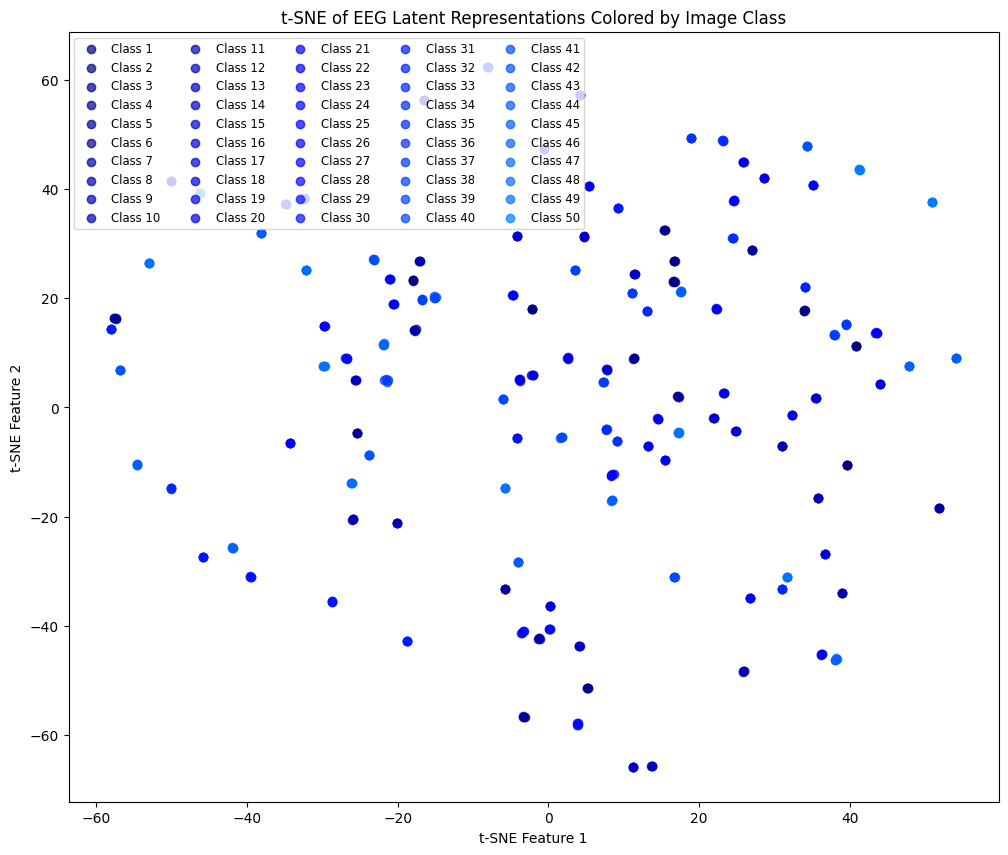

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create labels for each group of EEG latents (10 latents per class, 50 classes)
labels = np.repeat(np.arange(50*4), 10)

# Unique colors for each class
colors = plt.cm.jet(np.linspace(0, 1, 50*4))

plt.figure(figsize=(12, 10))

# Scatter plot with different colors for each class
for i in range(50):
    idx = labels == i
    plt.scatter(latent_2d[idx, 0], latent_2d[idx, 1], color=colors[i], label=f'Class {i+1}', alpha=0.7)

plt.title("t-SNE of EEG Latent Representations Colored by Image Class")
plt.xlabel("t-SNE Feature 1")
plt.ylabel("t-SNE Feature 2")
plt.legend(loc='best', ncol=5, fontsize='small')
plt.show()


In [ ]:
n_classes = 50
n_images_per_class = 10
total_images = n_classes * n_images_per_class  # 500 in your case

eeg_labels = []
for class_label in range(n_classes):
    eeg_labels.extend([class_label] * n_images_per_class)

# Now eeg_labels is a list of 500 elements, where each element is the class label
# Convert it to a numpy array if needed
eeg_labels = np.array(eeg_labels)

# Verify the labels
print(eeg_labels)
print("Length of EEG labels:", len(eeg_labels))


[ 0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  7  7
  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9
  9  9  9  9 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 14 14 14 14
 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16
 16 16 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 19 19
 19 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20 20 20 21 21 21 21 21 21
 21 21 21 21 22 22 22 22 22 22 22 22 22 22 23 23 23 23 23 23 23 23 23 23
 24 24 24 24 24 24 24 24 24 24 25 25 25 25 25 25 25 25 25 25 26 26 26 26
 26 26 26 26 26 26 27 27 27 27 27 27 27 27 27 27 28 28 28 28 28 28 28 28
 28 28 29 29 29 29 29 29 29 29 29 29 30 30 30 30 30 30 30 30 30 30 31 31
 31 31 31 31 31 31 31 31 32 32 32 32 32 32 32 32 32

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Extract latent vectors for EEG data (you already have this step)
latent_vectors = extract_latents(cvae, eeg_data_tensor, device)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    latent_vectors, eeg_labels, test_size=0.2, random_state=42
)

# Train an SVM classifier
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train)

# Evaluate the classifier
y_pred = svm_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


ValueError: ignored

In [ ]:
y_pred

array([14, 32,  5, 25, 27, 11, 12, 42, 25,  5,  5, 29, 14, 16, 14, 13, 44,
       26, 11, 11, 35, 29, 42, 25, 25, 46, 29, 24, 25, 11,  9, 16, 11, 25,
        5, 11, 14, 19, 19, 11, 29, 25,  4,  5, 29,  2, 22, 38, 38,  2, 38,
       42,  5, 25, 14, 11, 11,  2, 11, 29, 29, 14, 10,  5, 11, 22, 22, 25,
       26, 22, 11,  2, 14, 11, 28, 44, 11,  4, 23, 16, 44, 11, 19, 22, 24,
       25,  2, 10, 28, 29, 38, 42, 11, 24, 25, 42, 25, 10, 25, 14])

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create and train the Random Forest classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

# Evaluate the classifier
y_pred_rf = rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf * 100:.2f}%")

Random Forest Accuracy: 5.00%


In [ ]:
y_pred_rf

array([ 6, 17, 49, 41,  2, 34, 21, 12,  6,  0, 24, 12, 24, 36, 29, 24, 13,
       42, 13, 23,  3, 38, 44,  1, 21, 21, 15, 17, 11, 11, 19, 19, 37, 30,
       13, 16, 41, 24, 36, 11, 32,  6, 12, 42, 28,  3, 43, 32, 34,  2, 13,
       30, 26, 22, 48, 11, 29, 41, 11, 32, 11, 22, 46, 48,  7, 38, 34, 22,
       22, 34, 11, 32, 16, 32, 38,  0, 11,  2, 44, 28, 16, 11, 17, 22, 20,
       11, 16,  2, 17, 22, 10, 18, 14, 32,  0, 37, 35,  7,  4, 45])

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Create and train the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_classifier.fit(X_train, y_train)

# Evaluate the classifier
y_pred_xgb = xgb_classifier.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb * 100:.2f}%")


XGBoost Accuracy: 3.00%


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Create and train the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # You can experiment with the number of neighbors
knn_classifier.fit(X_train, y_train)

# Evaluate the classifier
y_pred_knn = knn_classifier.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Accuracy: {accuracy_knn * 100:.2f}%")


KNN Accuracy: 6.00%


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size // 4, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out

# Assuming your latent vector size and number of classes
input_size = latent_vectors.shape[1]
hidden_size = 128  # You can experiment with this
num_classes = 50  # As you have 50 image classes
model = SimpleNN(input_size, hidden_size, num_classes)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.optim as optim

# Convert the data to PyTorch tensors
X_tensor = torch.tensor(latent_vectors).float()
y_tensor = torch.tensor(eeg_labels).long()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Create dataloaders
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(1000):  # You can experiment with the number of epochs
    for i, (inputs, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/1000], Loss: {loss.item():.4f}')


Epoch [1/1000], Loss: 2.8179
Epoch [2/1000], Loss: 2.0664
Epoch [3/1000], Loss: 1.7784
Epoch [4/1000], Loss: 2.1769
Epoch [5/1000], Loss: 2.5807
Epoch [6/1000], Loss: 2.2093
Epoch [7/1000], Loss: 1.8144
Epoch [8/1000], Loss: 2.1337
Epoch [9/1000], Loss: 2.1502
Epoch [10/1000], Loss: 1.3526
Epoch [11/1000], Loss: 2.2591
Epoch [12/1000], Loss: 2.1695
Epoch [13/1000], Loss: 2.0150
Epoch [14/1000], Loss: 1.6109
Epoch [15/1000], Loss: 2.0138
Epoch [16/1000], Loss: 1.6352
Epoch [17/1000], Loss: 1.3663
Epoch [18/1000], Loss: 2.3407
Epoch [19/1000], Loss: 2.0000
Epoch [20/1000], Loss: 2.1630
Epoch [21/1000], Loss: 1.6104
Epoch [22/1000], Loss: 0.9834
Epoch [23/1000], Loss: 2.1009
Epoch [24/1000], Loss: 1.6838
Epoch [25/1000], Loss: 2.1736
Epoch [26/1000], Loss: 1.4327
Epoch [27/1000], Loss: 1.7282
Epoch [28/1000], Loss: 1.8055
Epoch [29/1000], Loss: 2.1651
Epoch [30/1000], Loss: 1.9157
Epoch [31/1000], Loss: 1.3067
Epoch [32/1000], Loss: 1.6681
Epoch [33/1000], Loss: 1.7774
Epoch [34/1000], Lo

In [ ]:
# Test the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on the test data: {accuracy:.2f}%')


Accuracy of the network on the test data: 8.00%


In [ ]:
latent_vectors.shape

(500, 50)

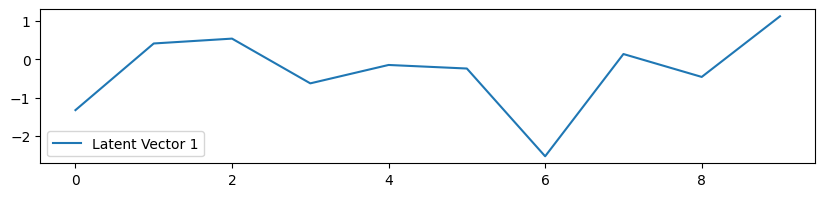

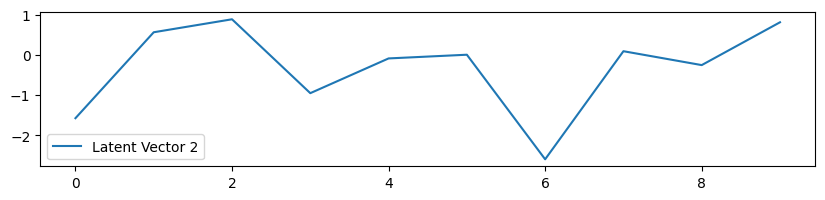

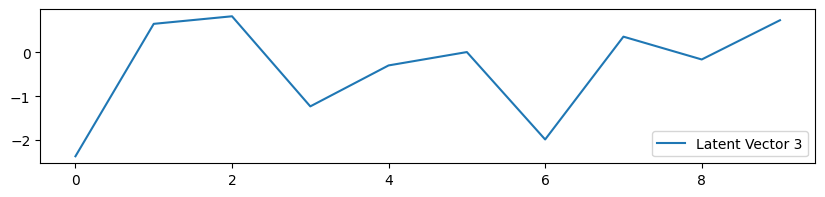

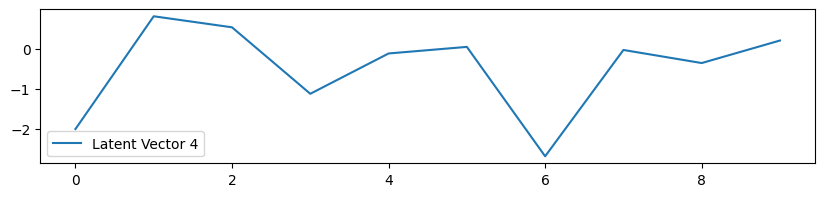

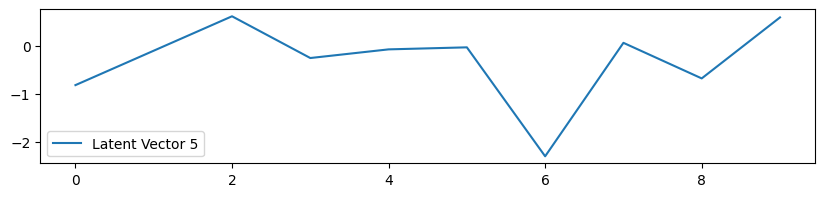

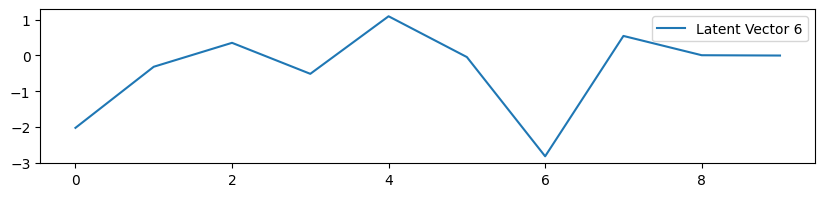

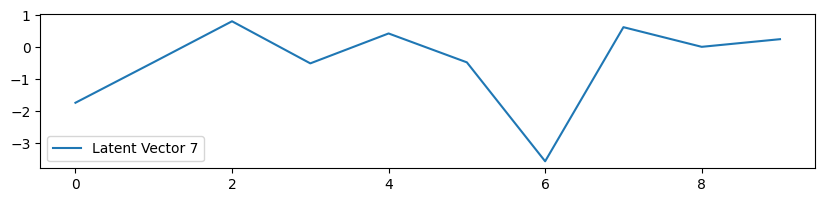

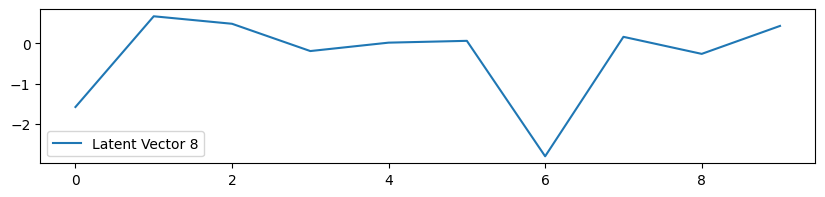

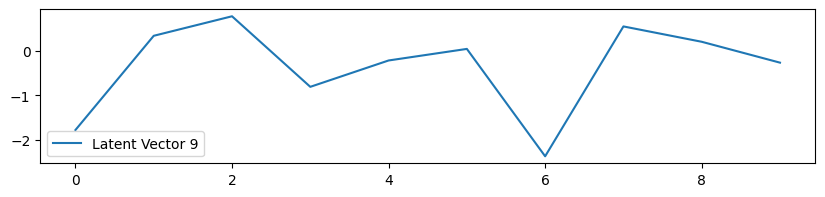

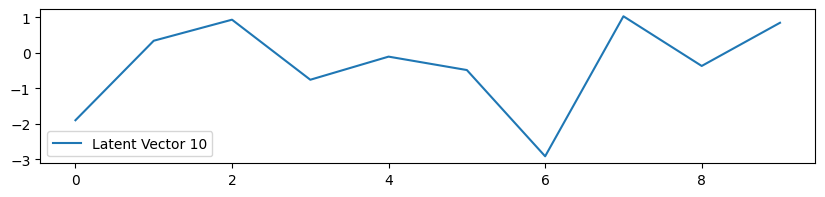

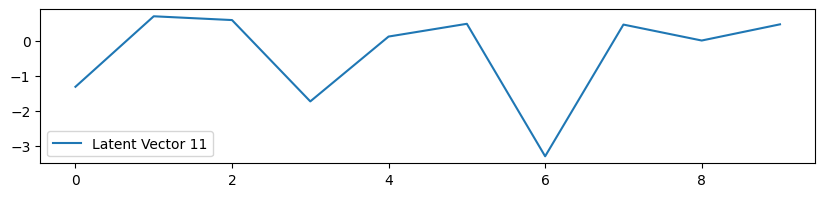

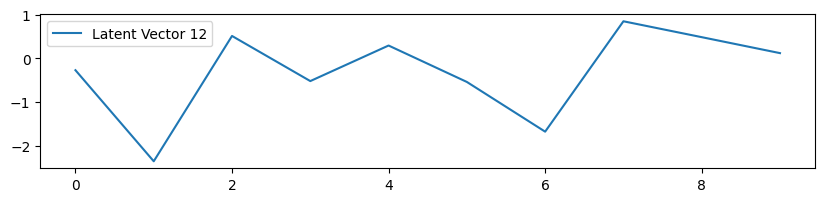

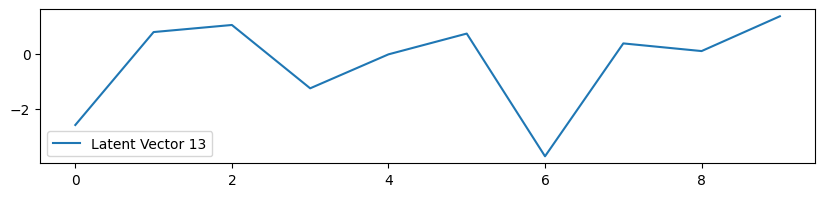

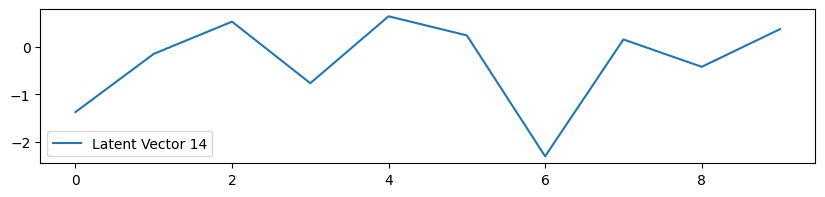

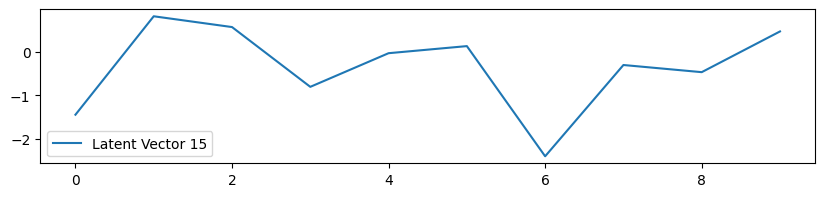

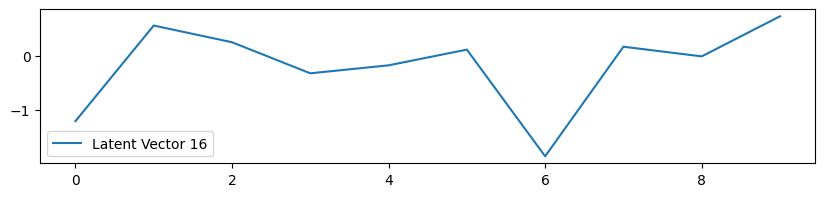

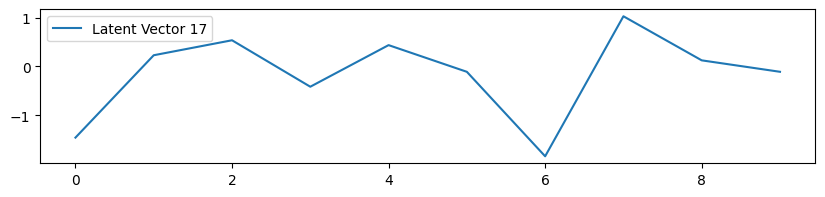

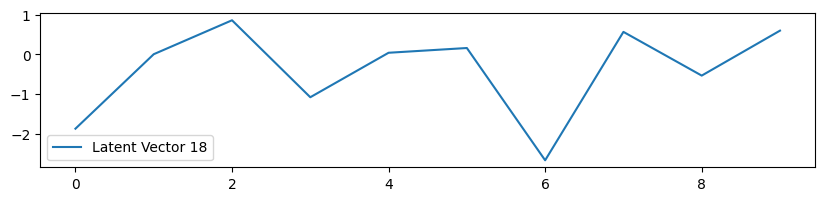

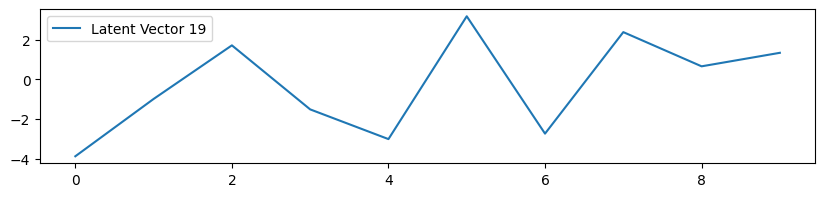

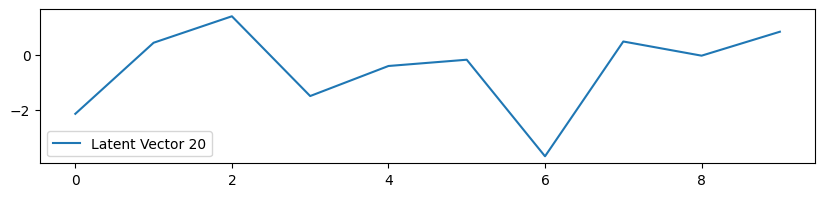

In [ ]:
# Assuming latent_vectors is a NumPy array of shape (500, 50)
# Let's plot the first 10 latent vectors as time series
for i in range(20):
    plt.figure(figsize=(10, 2))
    plt.plot(latent_vectors[i, :], label=f'Latent Vector {i+1}')
    plt.legend()
    plt.show()

(500, 4, 17, 100)

In [ ]:
class CVAE(nn.Module):
    def __init__(self, eeg_sequence_length, eeg_channels, image_size, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim

        # EEG encoder
        self.eeg_lstm = nn.LSTM(input_size=eeg_channels, hidden_size=128, num_layers=1, batch_first=True)
        self.eeg_dropout = nn.Dropout(0.5)
        self.eeg_to_latent = nn.Linear(128 * eeg_sequence_length, latent_dim * 2)  # Outputting mean and log-variance

        # Image encoder
        self.image_encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(image_size, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim * 2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, image_size),
            nn.Sigmoid()  # Assuming images are normalized between 0 and 1
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, eeg, image):
        # Process EEG data through LSTM and dropout layers
        eeg, _ = self.eeg_lstm(eeg)
        eeg = self.eeg_dropout(eeg)
        eeg = eeg.reshape(eeg.shape[0], -1)  # Flatten the output for the linear layer
        eeg_latent = self.eeg_to_latent(eeg)

        # Process image data
        image_latent = self.image_encoder(image)

        # Split the result into mean and log-variance
        eeg_mu, eeg_log_var = torch.chunk(eeg_latent, 2, dim=1)
        image_mu, image_log_var = torch.chunk(image_latent, 2, dim=1)

        # Combine EEG and image information in latent space
        mu = (eeg_mu + image_mu) / 2
        log_var = (eeg_log_var + image_log_var) / 2

        z = self.reparameterize(mu, log_var)
        recon_image = self.decoder(z)
        return recon_image, mu, log_var, eeg_mu, eeg_log_var

# Initialize the model
eeg_sequence_length = 100  # Number of time points in EEG sequence
eeg_channels = 17  # Number of EEG channels
image_size = 64 * 64 * 3  # Adjust for your image size
latent_dim = 50  # You can experiment with this